Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.1CKRUR_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Sample 1 - true label: Dog


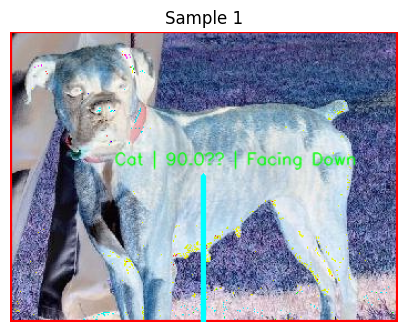

Sample 2 - true label: Dog


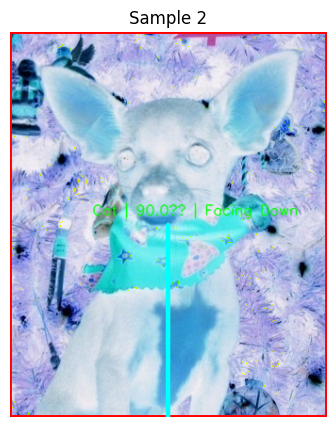

Sample 3 - true label: Dog


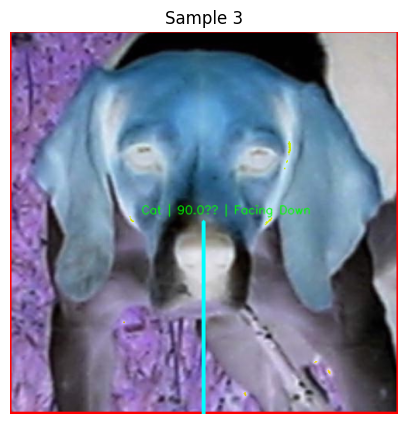

Sample 4 - true label: Cat


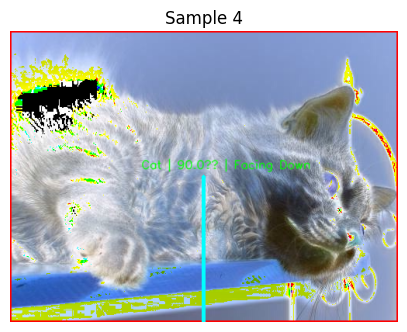

In [ ]:
# Simple prototype: Classification + Detection + Angle
# pip install tensorflow tensorflow-datasets opencv-python matplotlib --quiet

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# ----- Config -----
IMG_SIZE = 128          # classifier input size
MIN_CONTOUR_AREA = 3000 # ignore tiny contours

# ----- Helper to show images -----
def show_bgr(img_bgr, title=""):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5)); plt.imshow(img_rgb); plt.title(title); plt.axis('off'); plt.show()

# ----- 1) Load tiny sample from tfds (few examples) -----
ds, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
train = ds['train']  # dataset object

# pick first 4 images (2 cats, 2 dogs) for demo
samples = []
for image, label in train:
    arr = (image.numpy() * 255).astype(np.uint8)
    samples.append((arr, int(label.numpy())))
    if len(samples) >= 4:
        break

# ----- 2) Simple classifier (MobileNetV2 base, frozen) -----
base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base.trainable = False
model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')       # binary: dog (1) vs cat (0)
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# NOTE: For a real run, you'd train or load weights. Here we'll skip heavy training:
# - Option A (fast demo): don't train and use the mean color rule below as fallback
# - Option B (if you want to train): uncomment the training code and provide a proper dataset
use_trained_model = False   # set True only if you have trained weights / time to train

if use_trained_model:
    # Example training snippet (only if you have time & compute):
    # prepare a tiny dataset, train a couple epochs
    def preprocess(image, label):
        img = tf.image.resize(image, (IMG_SIZE,IMG_SIZE)) / 255.0
        return img, label
    ds_small = train.take(2000).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
    model.fit(ds_small, epochs=3)
else:
    pass  # fallback: we will use a color heuristic for classification demo

# ----- 3) Detection + angle on each sample -----
def classify_fallback(img_rgb):
    """Very small fallback classifier: if mean red > mean green => dog, else cat.
       Used only when model isn't trained."""
    mred = img_rgb[:,:,0].mean()
    mgreen = img_rgb[:,:,1].mean()
    return "Dog" if mred > mgreen else "Cat"

def detect_and_draw(img_rgb):
    """Detect large objects, draw rotated box, arrow for orientation, and a label."""
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # simple threshold to separate subject from background (works okay for many photos)
    _, th = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)  # white background -> invert
    # find contours
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = img_bgr.copy()

    # classification: try model if trained else fallback
    if use_trained_model:
        img_r = cv2.resize(img_rgb, (IMG_SIZE,IMG_SIZE)).astype(np.float32)/255.0
        p = model.predict(np.expand_dims(img_r,0))[0][0]
        top_label = "Dog" if p > 0.5 else "Cat"
    else:
        top_label = classify_fallback(img_rgb)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < MIN_CONTOUR_AREA:
            continue
        # min area rect -> gives angle and rotated box
        rect = cv2.minAreaRect(cnt)   # ((cx,cy),(w,h),angle)
        (cx,cy),(w,h),angle = rect
        box = cv2.boxPoints(rect).astype(int)
        # draw rotated box
        cv2.drawContours(out, [box], 0, (0,0,255), 2)

        # arrow: use angle (convert to rad and draw)
        # Note: OpenCV angle: when rectangle width < height, angle is angle between vertical and box.
        ang_rad = math.radians(angle)
        x1, y1 = int(cx), int(cy)
        L = int(max(w,h)*0.6) + 20
        # convert angle to vector; flip y for image coordinates
        x2 = int(x1 + L * math.cos(ang_rad))
        y2 = int(y1 + L * math.sin(ang_rad))
        cv2.arrowedLine(out, (x1,y1), (x2,y2), (255,255,0), 3, tipLength=0.25)

        # decide facing direction in simple bins
        # using angle in degrees from rect
        direction = "Unknown"
        if -45 <= angle <= 45:
            direction = "Facing Right"
        elif 45 < angle <= 135:
            direction = "Facing Down"
        elif -135 <= angle < -45:
            direction = "Facing Up"
        else:
            direction = "Facing Left"

        label_text = f"{top_label} | {round(angle,2)}° | {direction}"
        cv2.putText(out, label_text, (x1-80, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

    return out

# ----- 4) Run demo on samples -----
for i,(img, label) in enumerate(samples):
    print(f"Sample {i+1} - true label: {'Dog' if label==1 else 'Cat'}")
    # make sure img is RGB uint8
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    out = detect_and_draw(img)
    show_bgr(out, title=f"Sample {i+1}")
